# Model setup and usage 

In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from model_helpers import preprocess_data, validate_data, evaluate_model, log_transform, plot_xgb_feature_importance

data_location = '../data/raw/psp_raw_data.xlsx'

In [2]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured']  # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(log_transform, validate=True)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),  # Drop none so we can check the feature importance
        ('binary', 'passthrough', binary_features)
    ]
)

# Updated classifier with best parameters
classifier = XGBClassifier(
    colsample_bytree=0.724478254120072,
    learning_rate=0.005259243138699339,
    max_depth=7,
    min_child_weight=2,
    n_estimators=119,
    scale_pos_weight=3.8541165142031777,
    subsample=0.7212822750999782,
    random_state=42
)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Train the final model on the entire dataset
pipeline.fit(X, y)

Validation complete and successful.
None


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_and_scale',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x30463a980>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount']),
                                                 ('cat', OneHotEncoder(),
                                                  ['country', 'card', 'psp']),
                                                 ('binary', 'passthrough',
                                                  ['3d_secured'])])),
                ('classifier',
                 XGBClassifier(base_s...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005259243138699339, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=119, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## Evaluate Model

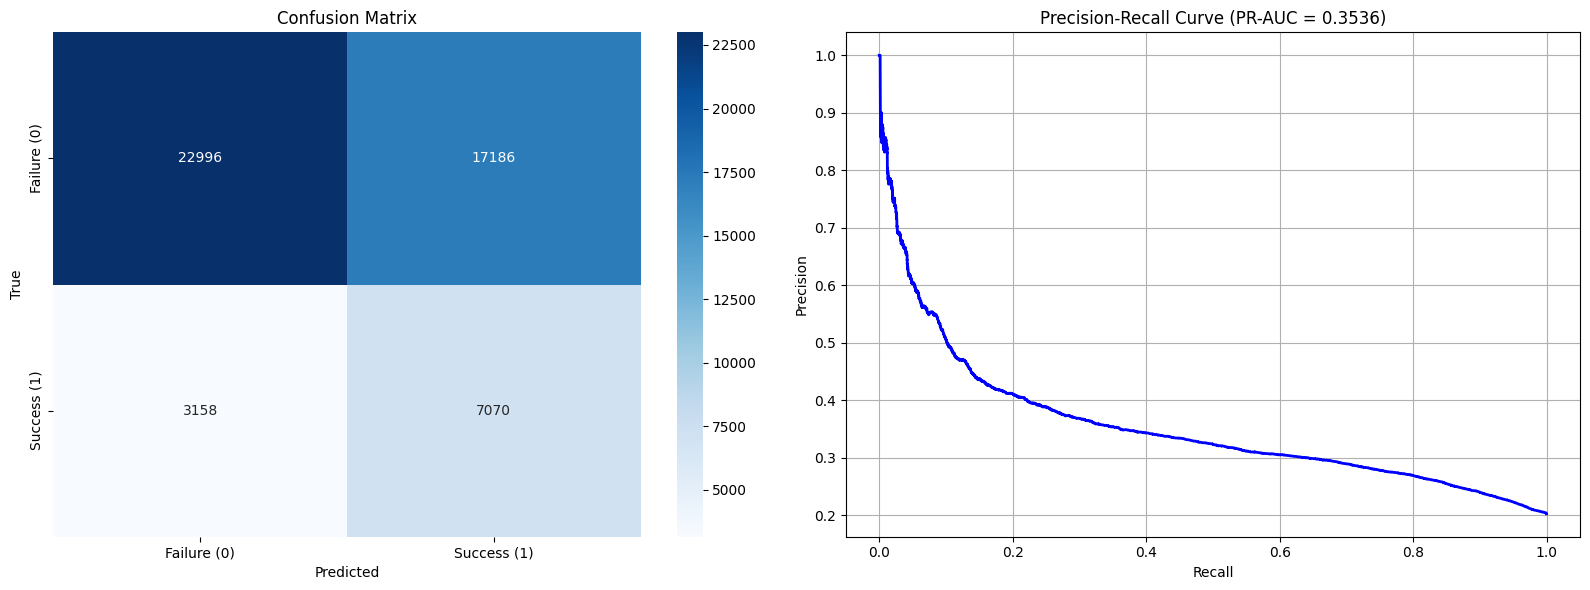


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.879254,0.572296,0.693319,40182.000000
Success (1),0.291474,0.691240,0.410045,10228.000000
accuracy,0.596429,0.596429,0.596429,0.596429
macro avg,0.585364,0.631768,0.551682,50410.000000
weighted avg,0.759995,0.596429,0.635844,50410.000000


Best F1-Score: 0.4111 at Threshold: 0.5013
Total Model F1-Score: 0.4100
Total Model Precision: 0.2915


In [3]:
evaluate_model(pipeline, X, y)

## Check Feature Importance

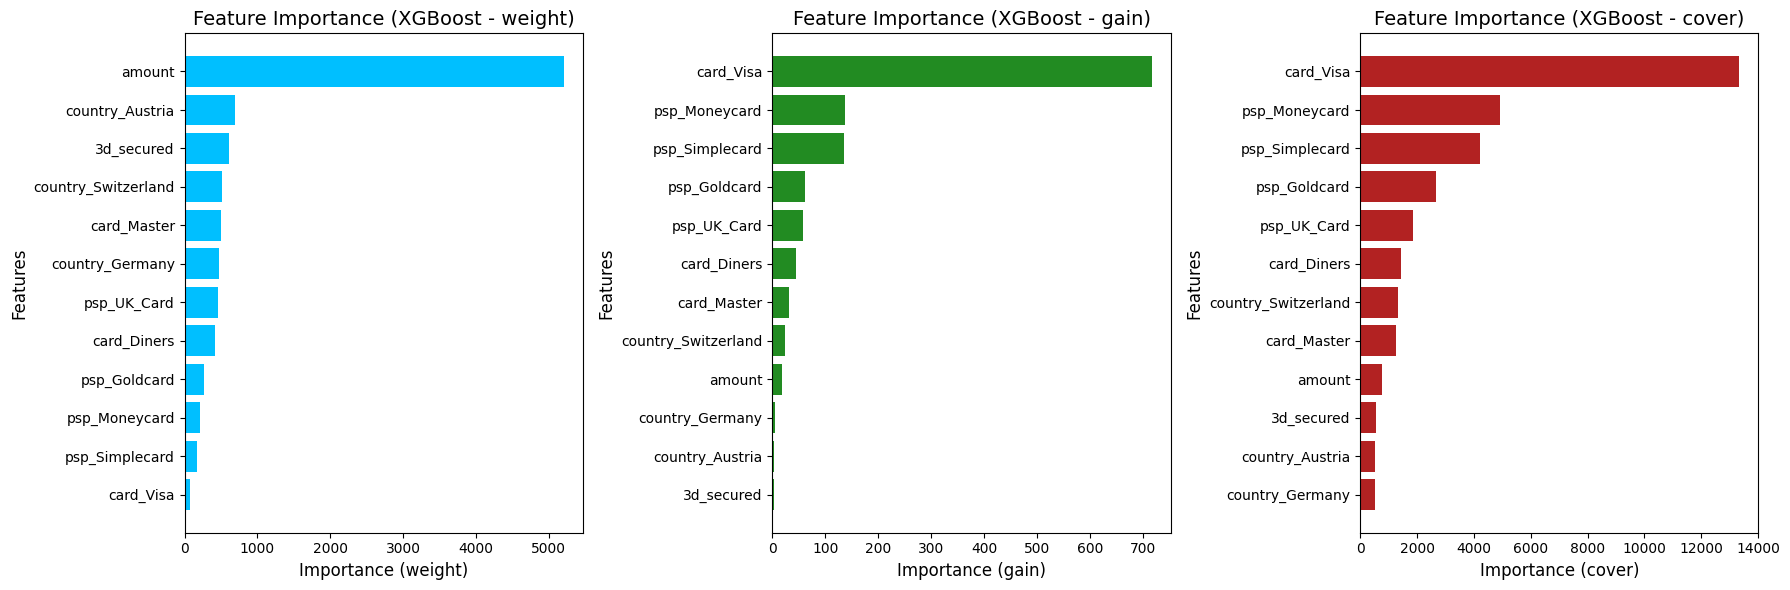

Feature Importance (Weight): {'amount': 5209.0, 'country_Austria': 691.0, '3d_secured': 606.0, 'country_Switzerland': 510.0, 'card_Master': 501.0, 'country_Germany': 473.0, 'psp_UK_Card': 457.0, 'card_Diners': 423.0, 'psp_Goldcard': 272.0, 'psp_Moneycard': 212.0, 'psp_Simplecard': 176.0, 'card_Visa': 80.0}
Feature Importance (Gain): {'card_Visa': 715.4461059570312, 'psp_Moneycard': 136.9369354248047, 'psp_Simplecard': 135.4307098388672, 'psp_Goldcard': 62.06884002685547, 'psp_UK_Card': 58.433231353759766, 'card_Diners': 44.949920654296875, 'card_Master': 31.77451515197754, 'country_Switzerland': 23.892017364501953, 'amount': 18.626474380493164, 'country_Germany': 3.919576406478882, 'country_Austria': 3.6313636302948, '3d_secured': 3.4549379348754883}
Feature Importance (Cover): {'card_Visa': 13344.296875, 'psp_Moneycard': 4934.474609375, 'psp_Simplecard': 4207.486328125, 'psp_Goldcard': 2677.8056640625, 'psp_UK_Card': 1867.410400390625, 'card_Diners': 1417.244140625, 'country_Switzerla

In [4]:
# plot importance scores 
importance_scores = plot_xgb_feature_importance(pipeline, numerical_features, binary_features, categorical_features)

print("Feature Importance (Weight):", importance_scores['weight'])
print("Feature Importance (Gain):", importance_scores['gain'])
print("Feature Importance (Cover):", importance_scores['cover'])

## Pickel final model for usage

In [5]:
# pickle model
with open('../models/psp_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)
print("Model saved successfully.")

Model saved successfully.
